# Train and Tune Linear Regression Model with MultioutputRegressor

In [1]:
from pathlib import Path

import optuna.visualization as vis
import pandas as pd

from config.config import Config
from src.models.factory import Experiment
from src.models.xgboost import XGBoost
from src.plots import plot_forecast_diagnostics, plot_forecast_next_h, plot_test_overlay_h1, prep_h1_overlay, \
    prep_h_overlay
from src.runners import run_experiments
from src.utils import set_seed

In [2]:
cfg = Config(Path("../config/config.yaml"))
SEED = cfg.runtime.seed
HORIZON = cfg.runtime.horizon
rng = set_seed(SEED)

2025-08-24 18:48:17,354 - INFO - src.utils - Global random seed set to 42


In [3]:
df_full = pd.read_csv(Path(cfg.data.processed_dir) / "features_full.csv")

In [4]:
# # GPU Variant
# experiments = [
#     Experiment(
#         name="xgboost",
#         build=lambda horizon, seed: XGBoost(
#             horizon=horizon,
#             random_state=seed,
#             device="cuda",
#             n_jobs=1,
#             outer_n_jobs=1,
#             n_estimators=400,
#             learning_rate=0.05,
#             max_depth=5,
#             subsample=0.8,
#             colsample_bytree=0.8,
#             max_bin=128,
#             grow_policy="depthwise",
#             eval_metric="rmse",
#             objective="reg:squarederror",
#         ),
#         include_sentiment=True,
#     )
# ]

In [5]:
# CPU Variant
experiments = [
    Experiment(
        name="xgboost_cpu",
        build=lambda horizon, seed: XGBoost(
            horizon=horizon,
            random_state=seed,
            device="cpu",
            n_jobs=-1,
            outer_n_jobs=-1,
            n_estimators=400,
            learning_rate=0.06,
            max_depth=5,
            subsample=0.8,
            colsample_bytree=0.8,
            max_bin=128,
            grow_policy="depthwise",
            eval_metric="rmse",
            objective="reg:squarederror",
        ),
        include_sentiment=True,
    )
]

In [6]:
results = run_experiments(df_full, Path(cfg.data.processed_dir), experiments, HORIZON, SEED)

2025-08-24 18:48:17,495 - INFO - ModelTrainer - Initialized ModelTrainer for model: xgboost_cpu
D:\IntelliJ\ml-stock-sent\.venv\Lib\site-packages\optuna\_experimental.py:32: ExperimentalWarning: Argument ``multivariate`` is an experimental feature. The interface can change in the future.
  warnings.warn(
D:\IntelliJ\ml-stock-sent\.venv\Lib\site-packages\optuna\_experimental.py:32: ExperimentalWarning: Argument ``constant_liar`` is an experimental feature. The interface can change in the future.
  warnings.warn(
[I 2025-08-24 18:48:17,497] A new study created in memory with name: no-name-127aba6d-dcf0-4c2c-b927-e04f43bdb3df
2025-08-24 18:48:17,499 - INFO - ModelTrainer - Starting model tuning...
2025-08-24 18:48:17,515 - INFO - ModelTrainer - Starting model tuning...
2025-08-24 18:48:17,517 - INFO - ModelTrainer - Starting model tuning...
2025-08-24 18:48:17,518 - INFO - ModelTrainer - Starting model tuning...
2025-08-24 18:48:17,521 - INFO - ModelTrainer - Starting model tuning...
2025

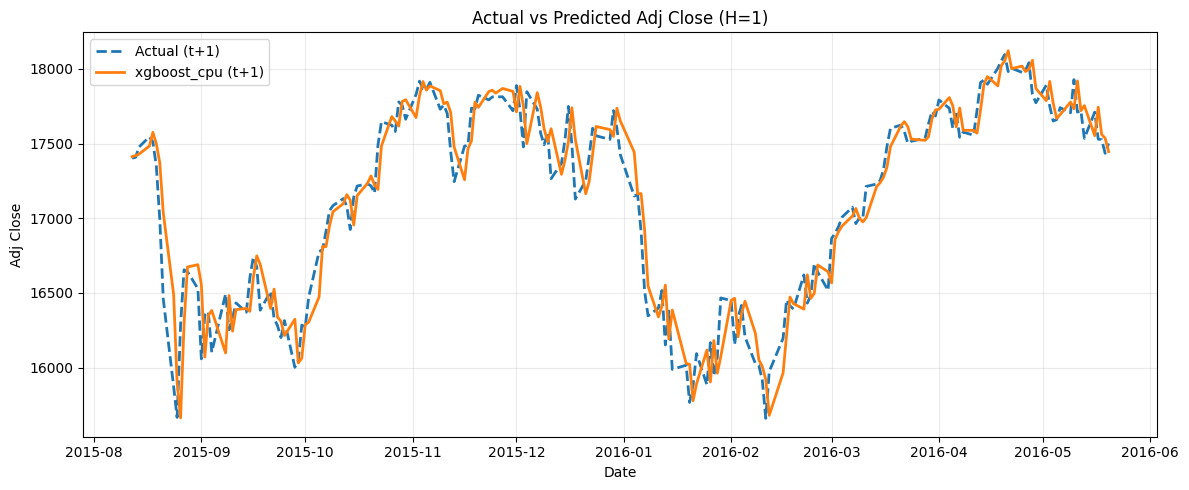

In [7]:
dates_next, actual_next, pred_next_by_model = prep_h1_overlay(df_full, results)
plot_test_overlay_h1(
    dates_next=dates_next,
    actual_next=actual_next,
    pred_next_by_model=pred_next_by_model,
    path=Path(cfg.data.fig_dir) / "xgboost_actual_vs_predicted_adj_close.png",
)

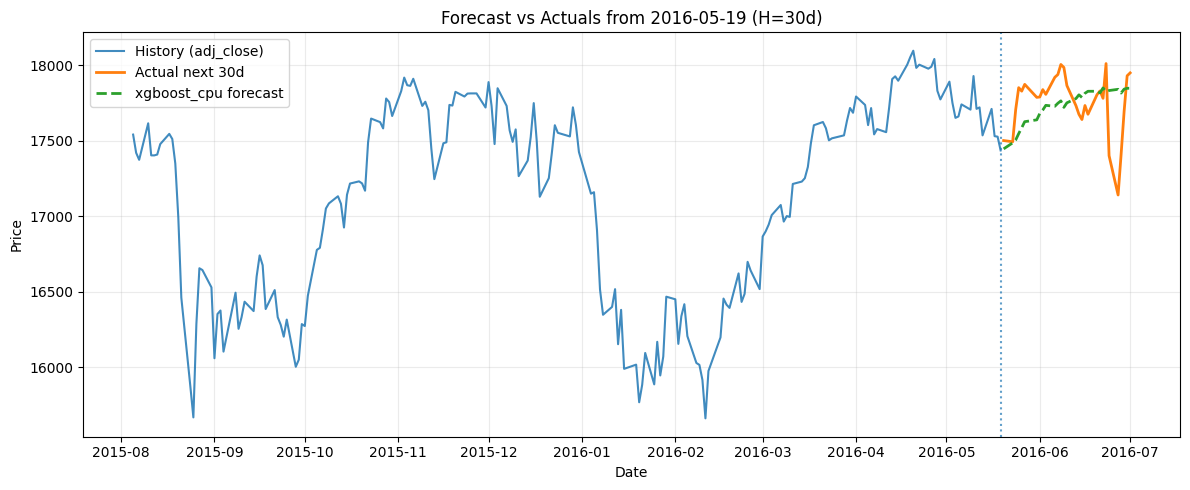

In [8]:
hist_dates, hist_prices, fut_dates, actual_path, anchor_date, paths_by_model = prep_h_overlay(df_full, results, HORIZON)
plot_forecast_next_h(
    hist_dates=hist_dates,
    hist_prices=hist_prices,
    fut_dates=fut_dates,
    forecast_paths_by_model=paths_by_model,
    actual_path=actual_path,
    anchor_date=anchor_date,
    H=HORIZON,
    path=Path(cfg.data.fig_dir) / "xgboost_forecast.png",
)

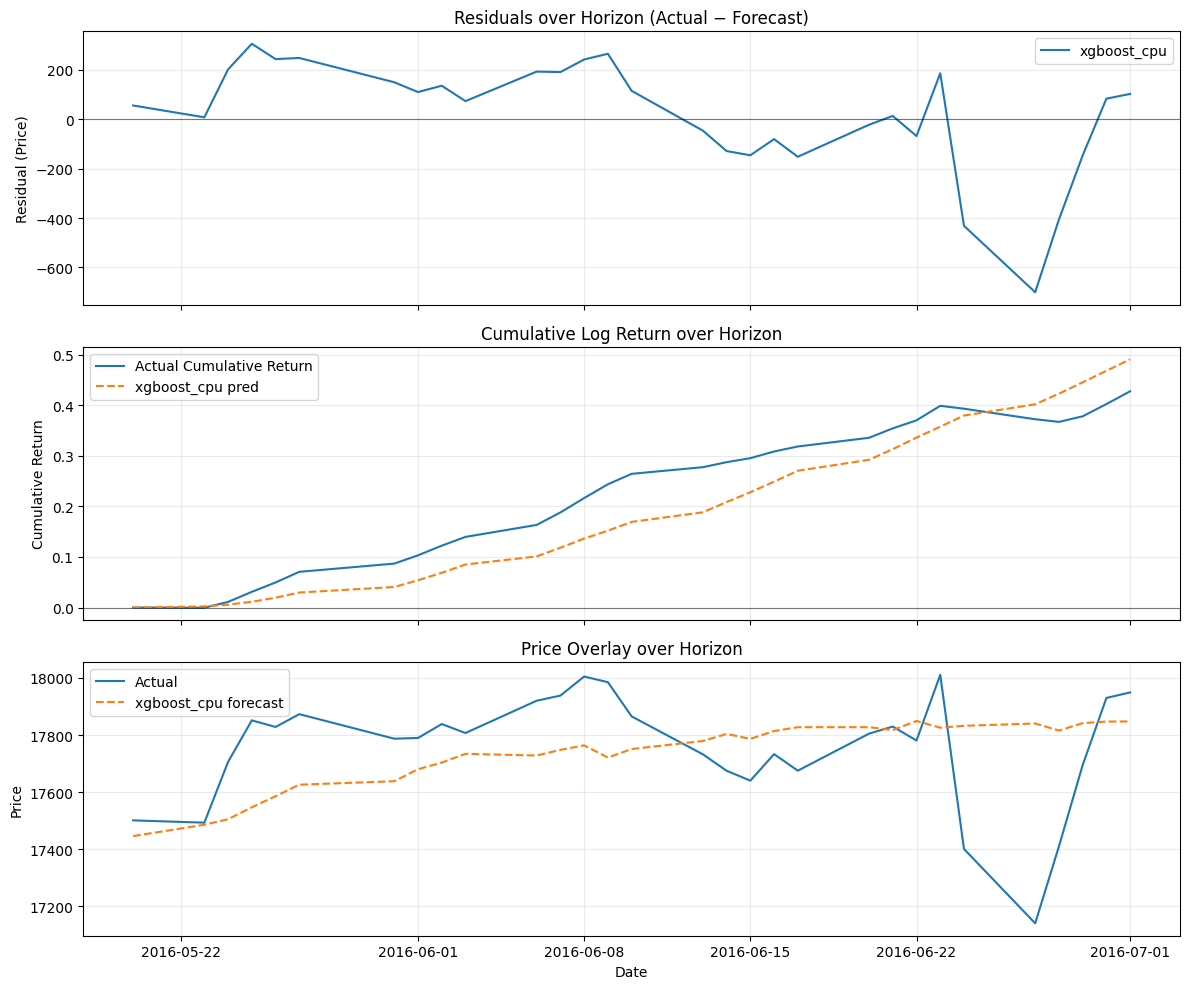

In [9]:
plot_forecast_diagnostics(
    fut_dates=fut_dates,
    actual_path=actual_path,
    forecast_paths_by_model=paths_by_model,
    path=Path(cfg.data.fig_dir) / "xgboost_forecast_diagnostics.png",
)

In [10]:
pd.DataFrame(results[0]["best_params"], index=[0])

,n_estimators,learning_rate,max_depth,subsample,colsample_bytree,min_child_weight,reg_alpha,reg_lambda,early_stopping_rounds,max_bin,grow_policy,objective,eval_metric,tree_method,max_leaves,random_state
0,400,0.020215,3,0.838716,0.659725,1.753553,0.692067,1.934843,100,512,depthwise,reg:absoluteerror,rmse,hist,0,42


In [11]:
pd.DataFrame(results[0]["metrics"]["test"], index=[0])

,mae,mse,rmse,smape,r2
0,0.007658,0.000102,0.010078,1.653203,-0.021583


In [12]:
study = results[0]["study"]

vis.plot_optimization_history(study).show()
vis.plot_param_importances(study).show()
vis.plot_slice(study).show()
vis.plot_parallel_coordinate(study).show()
vis.plot_contour(study).show()
vis.plot_edf(study).show()